# Optuna Dashboard Database Analysis

This notebook reads an Optuna dashboard SQLite database (`pid_optimize.db`), extracts data for studies of interest, and visualizes both the loss (objective value) and the evolution of PID parameters per trial.

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up display style
# sns.set(style="whitegrid")

## Connect to database

In [20]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up display style
# sns.set(style="whitegrid")

# ---------------------------
# 1. Connect to the Database
# ---------------------------
db_path = "pid_optimize.db"  # change if needed
conn = sqlite3.connect(db_path)

# Read studies table
studies_df = pd.read_sql_query("SELECT * FROM studies", conn)
print("Studies in DB:")
print(studies_df)

# For demonstration, we select the first study.
# Alternatively, you could filter by study name if needed:
# study_id = studies_df[studies_df['study_name'] == 'MyStudyName']['study_id'].iloc[0]
study_id = studies_df['study_id'].iloc[0]
print(f"\nUsing study_id: {study_id}")

# ---------------------------
# 2. Extract Data from Trials and Trial Params
# ---------------------------
# Read trials table for the study of interest
trials_df = pd.read_sql_query(f"SELECT * FROM trials WHERE study_id = {study_id}", conn)
print("\nTrials (first few rows):")
print(trials_df.head())

# Read trial_params table (contains one row per parameter per trial)
params_df = pd.read_sql_query("SELECT * FROM trial_params", conn)
print("\nTrial Parameters (first few rows):")
print(params_df.head())

# Close the connection once data is read
conn.close()

Studies in DB:
   study_id          study_name
0         1  PID_SL287_20250218

Using study_id: 1

Trials (first few rows):
   trial_id  number  study_id     state              datetime_start  \
0         1       0         1  COMPLETE  2025-02-18 16:24:32.001266   
1         2       1         1  COMPLETE  2025-02-18 16:25:24.192487   
2         3       2         1  COMPLETE  2025-02-18 16:25:41.286679   
3         4       3         1  COMPLETE  2025-02-18 16:25:58.382681   
4         5       4         1  COMPLETE  2025-02-18 16:26:15.478144   

            datetime_complete  
0  2025-02-18 16:25:24.164492  
1  2025-02-18 16:25:41.263679  
2  2025-02-18 16:25:58.357685  
3  2025-02-18 16:26:15.454141  
4  2025-02-18 16:26:32.545966  

Trial Parameters (first few rows):
   param_id  trial_id param_name  param_value  \
0         1         1   Kp_inhib     6.071804   
1         2         1   Ki_inhib     6.098023   
2         3         1   Kd_inhib    55.487047   
3         4         1  Kp

In [6]:
# ---------------------------
# 3. Process and Merge the Data
# ---------------------------

# Pivot trial_params so that each trial_id becomes a row with parameters as columns
pivot_params = params_df.pivot(index="trial_id", columns="param_name", values="param_value").reset_index()

# Merge the pivoted parameters with the trials dataframe
merged_df = pd.merge(trials_df, pivot_params, on="trial_id", how="left")

# Sort by trial number if available, otherwise by trial_id
if 'number' in merged_df.columns:
    merged_df.sort_values(by="number", inplace=True)
    x_col = "number"
else:
    merged_df.sort_values(by="trial_id", inplace=True)
    x_col = "trial_id"

merged_df.reset_index(drop=True, inplace=True)
print("\nMerged Trial Data (first few rows):")
print(merged_df.head())


Merged Trial Data (first few rows):
   trial_id  number  study_id     state              datetime_start  \
0         1       0         1  COMPLETE  2025-02-18 16:24:32.001266   
1         2       1         1  COMPLETE  2025-02-18 16:25:24.192487   
2         3       2         1  COMPLETE  2025-02-18 16:25:41.286679   
3         4       3         1  COMPLETE  2025-02-18 16:25:58.382681   
4         5       4         1  COMPLETE  2025-02-18 16:26:15.478144   

            datetime_complete  Kd_excite    Kd_inhib  Ki_excite  Ki_inhib  \
0  2025-02-18 16:25:24.164492        1.0   55.487047        1.0  6.098023   
1  2025-02-18 16:25:41.263679        1.0  188.392826        1.0  8.298004   
2  2025-02-18 16:25:58.357685        1.0  108.470823        1.0  8.789591   
3  2025-02-18 16:26:15.454141        1.0   71.935748        1.0  8.847907   
4  2025-02-18 16:26:32.545966        1.0  187.600983        1.0  5.456736   

   Kp_excite  Kp_inhib  
0        1.0  6.071804  
1        1.0  3.300764 

In [17]:
trials_df.head()

,trial_id,number,study_id,state,datetime_start,datetime_complete
0,1,0,1,COMPLETE,2025-02-18 16:24:32.001266,2025-02-18 16:25:24.164492
1,2,1,1,COMPLETE,2025-02-18 16:25:24.192487,2025-02-18 16:25:41.263679
2,3,2,1,COMPLETE,2025-02-18 16:25:41.286679,2025-02-18 16:25:58.357685
3,4,3,1,COMPLETE,2025-02-18 16:25:58.382681,2025-02-18 16:26:15.454141
4,5,4,1,COMPLETE,2025-02-18 16:26:15.478144,2025-02-18 16:26:32.545966


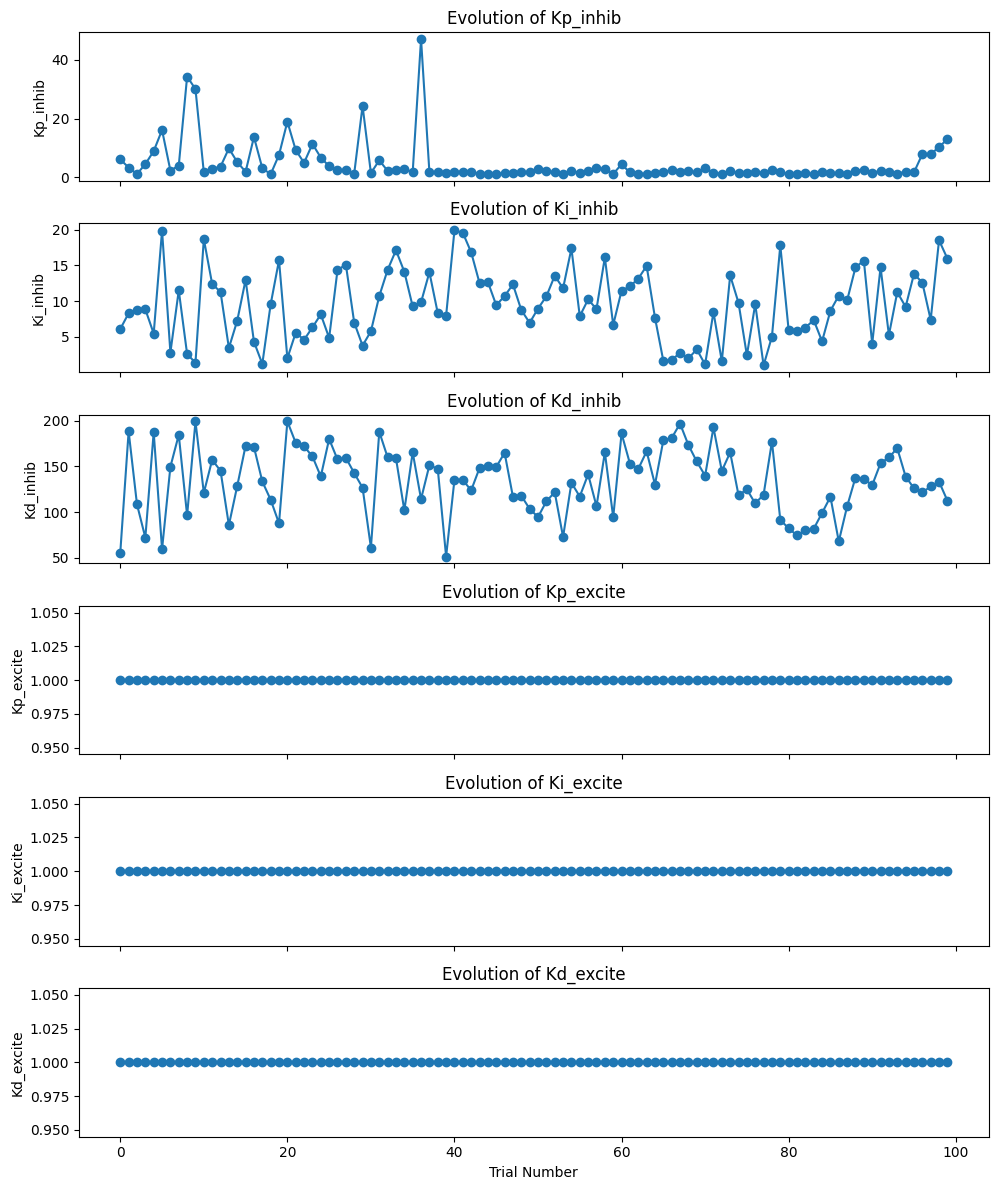

In [18]:
# ---------------------------
# 4. Visualize Loss and Parameter Changes
# ---------------------------

# Figure 1: Loss (Objective Value) per Trial
# plt.figure(figsize=(10, 4))
# plt.plot(merged_df[x_col], merged_df["value"], marker="o", linestyle="-")
# plt.xlabel("Trial Number")
# plt.ylabel("Objective Value (Loss)")
# plt.title("Loss per Trial")
# plt.tight_layout()
# plt.show()

# Figure 2: PID Parameter Evolution per Trial
# Assuming our parameter names are: "Kp_inhib", "Ki_inhib", "Kd_inhib", "Kp_excite", "Ki_excite", "Kd_excite"
pid_params = ["Kp_inhib", "Ki_inhib", "Kd_inhib", "Kp_excite", "Ki_excite", "Kd_excite"]
n_params = len(pid_params)
fig, axes = plt.subplots(n_params, 1, figsize=(10, 2 * n_params), sharex=True)
for i, param in enumerate(pid_params):
    if param in merged_df.columns:
        axes[i].plot(merged_df[x_col], merged_df[param], marker="o", linestyle="-")
        axes[i].set_ylabel(param)
        axes[i].set_title(f"Evolution of {param}")
    else:
        axes[i].text(0.5, 0.5, f"No data for {param}", horizontalalignment="center", verticalalignment="center")
axes[-1].set_xlabel("Trial Number")
plt.tight_layout()
plt.show()